In [1]:
from AsMac_model import AsMac
from AsMac_utility import *
import torch
torch.set_printoptions(profile="full")
np.set_printoptions(precision=10)
from torch import optim
import time
import os


In [2]:
# load data
seq_fp = 'data/training_seq.fa'
dist_fp = 'data/training_dist_prepared.txt'
batch_size = 5

# create data generator
training_data = SeqDataset(seq_fp, dist_fp, batch_size)

# sample random batch matrix and sequence list
for (seq_list, dist_m) in training_data:
    print('batch matrix:')
    print(dist_m)
    print('batch sequences:')
    for seq in seq_list:
        print(seq[0:100] + '...')
    break


batch matrix:
[[0.           0.2821174952 0.2608695652 0.3155497723 0.2535211268]
 [0.2821174952 0.           0.2868167203 0.3300589391 0.2957839262]
 [0.2608695652 0.2868167203 0.           0.2626728111 0.2227424749]
 [0.3155497723 0.3300589391 0.2626728111 0.           0.2738255034]
 [0.2535211268 0.2957839262 0.2227424749 0.2738255034 0.          ]]
batch sequences:
GAGTTTGATCATGGCTCAGAATCAACGCTGGCGGCGCGCTTAACACATGCAAGTCGAACGAGAAAGGGGAGCAATCCCTGAGTACAGTGGCGTCCGGGTG...
GATTATGGCTCAGGATGAACGCTAGCGGCAGGCTTAACACATGCAAGTCGCGGGGCAGCGGGGAAGGAGCTTGCTCCTTCCGCCGGCGACCGGCGCACGG...
ATTGAACGCTGGCGGCGTGCTTAACACATGCAAGTCGAGCGAGAAAGCTCTCTTCGGAGAGTGAGTAGAGCGGCGCACGGGTGAGTAACGCGTGGATAAT...
GATGAACGCTGGCGGCGTGCCTAATACATGCAAGTCGAGCGAACAGATAAGGAGCTTGCTCCTTTGAAGTTAGCGGCGGACGGGTGAGTAACACGTGGGT...
GATGAACGCTGGCGGCGTGCTTAACACATGCAAGTCGAACGAACCTTCGGGTTAGTGGCGGACGGGTGAGTAACGCGTGAGAATCTGCCCTCAGGAGGGG...


In [3]:
# define model
embed_dim = 300 # number of kernel sequences
kernel_size = 20 # kernel length
learning_rate=1e-3 # learning rate

# check and make model save dir
if not os.path.exists('result'):
    os.makedirs('result')

# initialize AsMac model
net = AsMac(4, embed_dim, kernel_size)
print(net)


AsMac(
(weight): SoftNW1d(4, 300, kernel_size=20)
)


In [4]:
# training
optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=0) # use adam optimizer
criterion = MSELoss() # define mean square error loss
max_iter = 1000 # training stopped at 1000 iterations
save_iter = 100 # save a temporary model per 100 iterations
running_cnt = 0
train_running_loss = 0
start = time.time() # start timer
for i, (seq_list, dist_m) in enumerate(training_data, 1):
    
    # convert nucleotides sequence to one-hot sequence
    seq_oh = one_hot(seq_list)
    predict_m = net(seq_oh) # prediction of AsMac
    dist_m = torch.Tensor(dist_m) # true alignment distance
    train_loss = criterion(predict_m, dist_m) # MSE loss
    train_running_loss += train_loss.data.item()
            
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step() # compute gradients
    
    running_cnt += 1
            
    if i % 10 == 0:
        t_record = time.time() - start
        batch_mean_loss = train_running_loss / running_cnt
        print('\rcost ' + time_cost(t_record) + ' done ' + str(i) + ' batches. train running loss: ' + ('%4.3e' % batch_mean_loss), end=' ')
        
    if i % save_iter == 0:
        print('\nrunning model saved')
        torch.save(net.state_dict(), 'result/demo_running.pt')
        train_running_loss = 0
        running_cnt = 0
    
    if i >= max_iter:
        torch.save(net.state_dict(), 'result/demo_finished.pt')
        print('model saved')
        break

cost  0h: 0m:48s done 100 batches. train running loss: 5.280e-02 
running model saved
cost  0h: 1m:36s done 200 batches. train running loss: 4.597e-02 
running model saved
cost  0h: 2m:25s done 300 batches. train running loss: 2.392e-02 
running model saved
cost  0h: 3m:13s done 400 batches. train running loss: 2.639e-03 
running model saved
cost  0h: 6m:52s done 500 batches. train running loss: 1.619e-03 
running model saved
cost  0h: 7m:41s done 600 batches. train running loss: 8.861e-04 
running model saved
cost  0h: 8m:29s done 700 batches. train running loss: 6.699e-04 
running model saved
cost  0h: 9m:17s done 800 batches. train running loss: 6.680e-04 
running model saved
cost  0h:10m: 5s done 900 batches. train running loss: 6.142e-04 
running model saved
cost  0h:10m:53s done 1000 batches. train running loss: 4.574e-04 
running model saved
model saved


In [7]:
# define testing function
def test(net, seq_fp, dist_fp):
    
    start = time.time() # tic
    
    test_data = SeqDataset(seq_fp, dist_fp, 10) # load data by initialize data generator
    seq_list = test_data.seq_list # list of sequences
    dist_m = test_data.M # true alignment distance matrix
    l = test_data.cnt # number of sequences, size of the full matrix

    seq_oh = one_hot(seq_list) # convert to one-hot
    predictions = net.test_forward(seq_oh).detach().numpy().astype(np.float64)
    dif_matrix = np.abs(predictions - dist_m)

    np.fill_diagonal(dist_m, 1) # fill diagnal to avoid divided-by-zero error
    mre = np.sum(np.divide(dif_matrix, dist_m)) / (pow(l, 2)-l)

    end = time.time() # toc
    print('mre: %4.2f%%, test time: %4.2fs' % (100*mre, (end - start)))

    # reshape upper triangle to list
    predictions = predictions[np.triu_indices(l, k = 1)]
    dists = dist_m[np.triu_indices(l, k = 1)]

    return predictions, dists, mre, (end - start)

mre: 3.64%, test time: 42.25s


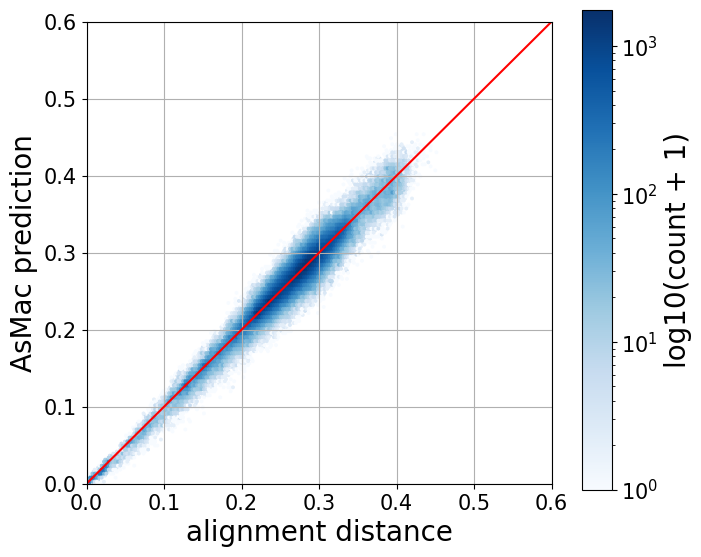

plot_saved


In [8]:
# testing
seq_fp = 'data/testing_seq.fa'
dist_fp = 'data/testing_dist_prepared.txt'
plot_sp = 'testing_scatter.png'

# load sufficiently trained weight for AsMac
net_state_dict = torch.load('model/16S-full.pt')
net.load_state_dict(net_state_dict)

predictions, dists, mre, t_cost = test(net, seq_fp, dist_fp)

# plot the scatter
my_plot(dists, predictions, plot_sp)